In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import pandas as pd

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [3]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18,
                     "xtick.minor.top":True, "ytick.minor.right":True,
                     "xtick.minor.visible": True,
                     "ytick.minor.visible": True})

In [4]:
# defining color palette for plotting
palette = {"low":"olive", "high":"salmon", 
           "difference":"#2C1D11", "difference2":"#464646"
          }    
        

# Import data

In [9]:
# to import data via individual snapshots
# low = {}
# high = {}

# for snap in range(100):
#     if snap == 48:
#         continue
    
#     low[str(snap)] = {} 
#     high[str(snap)] = {}
    
#     # low-mass pairs
#     f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_{snap}.hdf5",'r')
#     for key, val in f.items():
#         low[str(snap)][key] = np.array(val)
#     f.close()
    
#     # high-mass pairs
#     g = h5py.File(f"{paths.path_data}big-bad/massive_orbitdata_{snap}.hdf5",'r')
#     for key, val in g.items():
#         high[str(snap)][key] = np.array(val)
#     g.close()

# h = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
# convert = {}
# for key, val in h.items():
#     convert[key] = np.array(val)
# h.close()

In [140]:
# to import all pair and unique pair catalogs

low = {}
high = {}

    
# low-mass pairs
f = h5py.File(f"{paths.path_data}hail-mary/all_orbits.hdf5",'r')
for key, val in f.items():
    low[key] = np.array(val)
f.close()
    
# high-mass pairs
g = h5py.File(f"{paths.path_data}big-bad/all_orbits_massive.hdf5",'r')
for key, val in g.items():
    high[key] = np.array(val)
g.close()

# conversion between snapshot-redshift-time
h = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in h.items():
    convert[key] = np.array(val)
h.close()


# Count unique pairs


## load data

In [15]:
low_keys = low['PairKey']
high_keys = high['PairKey']

low_unique = np.unique(low_keys)
high_unique = np.unique(high_keys)

In [18]:
print(f"Number of total low mass pairs: {len(low_keys)}")
print(f"Number of unique low mass pairs: {len(low_unique)}")



Number of total low mass pairs: 71429
Number of unique low mass pairs: 22213


In [19]:
print(f"Number of total high mass pairs: {len(high_keys)}")
print(f"Number of unique high mass pairs: {len(high_unique)}")


Number of total high mass pairs: 20824
Number of unique high mass pairs: 3039


# Plot: Number of unique pairs vs. z

### Load data

In [24]:
# import unique pair catalogs

low = {}
high = {}

    
# low-mass pairs
f = h5py.File(f"{paths.path_data}hail-mary/unique_orbits.hdf5",'r')
for key, val in f.items():
    low[key] = np.array(val)
f.close()
    
# high-mass pairs
g = h5py.File(f"{paths.path_data}big-bad/unique_orbits_massive.hdf5",'r')
for key, val in g.items():
    high[key] = np.array(val)
g.close()

# conversion between snapshot-redshift-time
h = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in h.items():
    convert[key] = np.array(val)
h.close()


## test at one snapshot

In [77]:
# goal: to find the number of pairs at snapshot 40 that HAVE YET TO MERGE and are POST INFALL

# post infall means that the infall snapshot must be = or prior to 40
postinfall_at_40 = low['InfallSnapshot'] <= 40

# pre-merger means the merger snapshot must be after 40 OR be a non-merger
merge_later = low['MergeSnapshot'] > 40
non_mergers = low['MergeSnapshot'] == -1

unmerged_at_40 = merge_later|non_mergers

In [78]:
np.count_nonzero(postinfall_at_40&unmerged_at_40)

6574

## all snapshots

In [127]:
# calculate above for all snapshots

low_counts = []

for snap in convert['Snapshot']:
    # post infall means that the infall snapshot must be = or prior to 40
    postinfall_at_snap = low['InfallSnapshot'] <= snap

    # pre-merger means the merger snapshot must be after 40 OR be a non-merger
    merge_later = low['MergeSnapshot'] > snap
    non_mergers = low['MergeSnapshot'] == -1

    unmerged_at_snap = merge_later|non_mergers

    postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
    count = np.count_nonzero(postinfall_unmerged)
    
    postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
    count_merge = np.count_nonzero(postinfall_willmerge)

    low_counts.append([count,count_merge])
    
low_counts = np.array(low_counts)

In [129]:
low_counts[40]

array([6574, 5787])

In [126]:
# calculate above for all snapshots

high_counts = []

for snap in convert['Snapshot']:
    # post infall means that the infall snapshot must be = or prior to 40
    postinfall_at_snap = high['InfallSnapshot'] <= snap

    # pre-merger means the merger snapshot must be after 40 OR be a non-merger
    merge_later = high['MergeSnapshot'] > snap
    non_mergers = high['MergeSnapshot'] == -1

    unmerged_at_snap = merge_later|non_mergers

    postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
    count = np.count_nonzero(postinfall_unmerged)
    
    postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
    count_merge = np.count_nonzero(postinfall_willmerge)

    high_counts.append([count,count_merge])
    
high_counts = np.array(high_counts)


## pair count data from pears

In [180]:
f = h5py.File(f"{paths.path_home}pears/plots/paper1/plotdata/counts.hdf5",'r')
counts = f[f"10 Realizations"]

pears_low = {}
for key,val in counts['dwarf'].items():
    pears_low[key] = np.array(val)

pears_high = {}
for key,val in counts['massive'].items():
    pears_high[key] = np.array(val)

f.close()

## make pears equiv data from orbs

In [139]:
# to import data via individual snapshots
low_snap = {}

for snap in range(100):
    if snap == 48:
        continue
    
    low_snap[str(snap)] = {} 
    
    # low-mass pairs
    f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_{snap}.hdf5",'r')
    for key, val in f.items():
        low_snap[str(snap)][key] = np.array(val)
    f.close()

In [150]:
l40 = low_snap['40']

In [152]:
post = l40['InfallSnapshot'] <= 40
later = l40['MergeSnapshot'] > 40
non = l40['MergeSnapshot'] == -1

un = later|non

p_un = post & un # includes will merge & won't merge
p_later = post & later # includes will merge & won't merge


print(np.count_nonzero(p_un),np.count_nonzero(p_later))

1330 1198


In [164]:
np.array(infallsnap)

array([38, 37, 39, ..., 40, 40, 34], dtype=int32)

In [162]:
f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_40.hdf5",'r')
infallsnap = f['InfallSnapshot']
mergesnap = f['MergeSnapshot']


# post infall means that the infall snapshot must be = or prior to 40
postinfall_at_snap = infallsnap <= 40

# pre-merger means the merger snapshot must be after 40 OR be a non-merger
merge_later = f['MergeSnapshot'] > 40
non_mergers = f['MergeSnapshot'] == -1

f.close()

unmerged_at_snap = merge_later|non_mergers


postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
count = np.count_nonzero(postinfall_unmerged)

postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
count_merge = np.count_nonzero(postinfall_willmerge)



TypeError: '<=' not supported between instances of 'Dataset' and 'int'

In [165]:
f.close()

In [172]:
# calculate above for all snapshots

low_counts_snap = []

for snap in convert['Snapshot']:
    if snap == 48:
        low_counts_snap.append([np.nan,np.nan])
        continue

    f = h5py.File(f"{paths.path_data}hail-mary/orbitdata_{snap}.hdf5",'r')
    
    infallsnap = np.array(f['InfallSnapshot'])
    mergesnap = np.array(f['MergeSnapshot'])
    
    # post infall means that the infall snapshot must be = or prior to 40
    postinfall_at_snap = infallsnap <= snap

    # pre-merger means the merger snapshot must be after 40 OR be a non-merger
    merge_later = mergesnap > snap
    non_mergers = mergesnap == -1
    
    f.close()

    unmerged_at_snap = merge_later|non_mergers

    postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
    count = np.count_nonzero(postinfall_unmerged)
    
    postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
    count_merge = np.count_nonzero(postinfall_willmerge)

    low_counts_snap.append([count,count_merge])
        
    
low_counts_snap = np.array(low_counts_snap)

In [176]:
# calculate above for all snapshots

high_counts_snap = []

for snap in convert['Snapshot']:
    if snap == 48:
        high_counts_snap.append([np.nan,np.nan])
        continue

    f = h5py.File(f"{paths.path_data}big-bad/massive_orbitdata_{snap}.hdf5",'r')
    
    infallsnap = np.array(f['InfallSnapshot'])
    mergesnap = np.array(f['MergeSnapshot'])
    
    # post infall means that the infall snapshot must be = or prior to 40
    postinfall_at_snap = infallsnap <= snap

    # pre-merger means the merger snapshot must be after 40 OR be a non-merger
    merge_later = mergesnap > snap
    non_mergers = mergesnap == -1
    
    f.close()

    unmerged_at_snap = merge_later|non_mergers

    postinfall_unmerged = postinfall_at_snap&unmerged_at_snap # includes will merge & won't merge
    count = np.count_nonzero(postinfall_unmerged)
    
    postinfall_willmerge = postinfall_at_snap&merge_later # only will merge
    count_merge = np.count_nonzero(postinfall_willmerge)

    high_counts_snap.append([count,count_merge])
        
    
high_counts_snap = np.array(high_counts_snap)

In [167]:
low_counts_snap[40]

array([1330, 1198])

In [173]:
np.shape(low_counts_snap)

(100, 2)

In [177]:
pears_low.keys()

dict_keys(['Median All Pairs', 'Median Isolated Primaries', 'Median Major Fraction', 'Median Major Pairs', 'Median Minor Fraction', 'Median Minor Pairs', 'Median Noniso Primaries', 'Median Total Fraction', 'Median Total Primaries', 'Quarts All Pairs', 'Quarts Isolated Primaries', 'Quarts Major Fraction', 'Quarts Major Pairs', 'Quarts Minor Fraction', 'Quarts Minor Pairs', 'Quarts Noniso Primaries', 'Quarts Total Fraction', 'Quarts Total Primaries', 'z'])

## Make plot

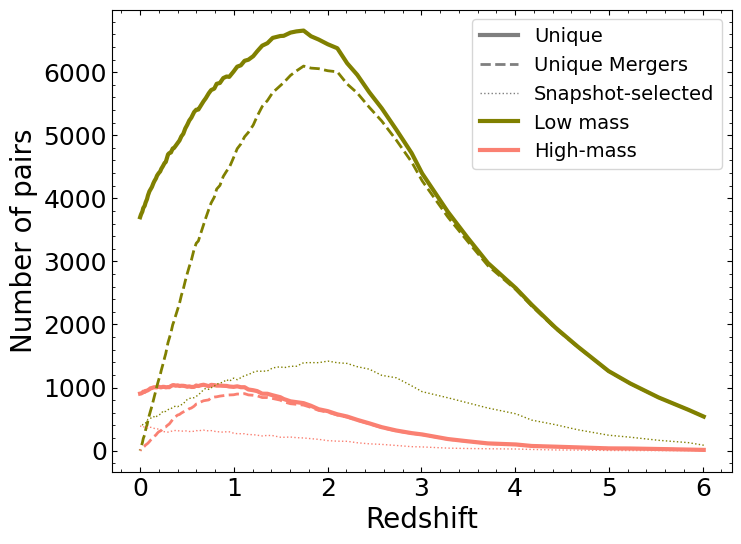

In [188]:
fig,ax = plt.subplots(figsize=(8,6))

ls_all = "solid"
ls_merge = "dashed"
ls_snap = "dotted"

lw_all = 3
lw_merge = 2
lw_snap = 1

# - plot labels - # 
plt.plot(0,0,label='Unique',color="tab:grey",lw=lw_all)
plt.plot(0,0,label='Unique Mergers',linestyle=ls_merge,color="tab:grey",lw=lw_merge)
plt.plot(0,0,label='Snapshot-selected',linestyle=ls_snap,color="tab:grey",lw=lw_snap)

# - unique pairs - # 
redshifts = convert["Redshift"]
redshift_mask = redshifts < 6.2

low_all = low_counts[:,0]
low_merge = low_counts[:,1]

high_all = high_counts[:,0]
high_merge = high_counts[:,1]

plot_red = redshifts[redshift_mask]

plot_low_all = low_all[redshift_mask]
plot_low_merge = low_merge[redshift_mask]

plot_high_all = high_all[redshift_mask]
plot_high_merge = high_merge[redshift_mask]

plt.plot(plot_red, plot_low_all, label='Low mass', color=palette['low'], lw=orbs_lw)
plt.plot(plot_red, plot_high_all, label='High-mass', color=palette['high'], lw=orbs_lw)

plt.plot(plot_red, plot_low_merge, color=palette['low'], lw=lw_merge, linestyle=ls_merge)
plt.plot(plot_red, plot_high_merge, color=palette['high'], lw=lw_merge, linestyle=ls_merge)

# - number selected at snapshot - #
redshift_mask[48] = False

plot_red = redshifts[redshift_mask]

plot_low_snap = low_counts_snap[:,0][redshift_mask]
pot_high_snap = high_counts_snap[:,0][redshift_mask]

plt.plot(plot_red, plot_low_snap, color=palette['low'],linestyle=ls_snap,lw=lw_snap)
plt.plot(plot_red, pot_high_snap, color=palette['high'],linestyle=ls_snap,lw=lw_snap)


plt.legend(fontsize=14)
# plt.title("Number of unique pairs")
plt.xlabel("Redshift")
plt.ylabel("Number of pairs")
plt.savefig("../../plots/bet-on-it/6_paircount.png")
plt.show()
